In [4]:
from src import JPLDGIMDataset
import matplotlib.pyplot as plt
import sys
import numpy as np
import torch

from graphcast import icosahedral_mesh, model_utils, grid_mesh_connectivity
from graphcast.typed_graph import NodeSet, EdgeSet, TypedGraph, Context, EdgeSetKey, EdgesIndices

# Load data


JPLD
Directory  : /mnt/ionosphere-data/jpld/webdataset
Loading tar files index from cache: /mnt/ionosphere-data/jpld/webdataset/tar_files_index
Start date : 2010-05-13 00:00:00
End date   : 2024-07-31 23:45:00
Delta      : 15 minutes
Loading dates from cache: /mnt/ionosphere-data/jpld/webdataset/dates_index_2010-05-13T00:00:00_2024-07-31T23:45:00
TEC maps total    : 498,623
TEC maps available: 498,481
TEC maps dropped  : 142
torch.Size([180, 360])


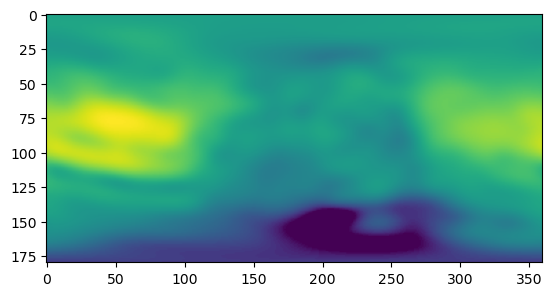

In [5]:
gim_dir = "/mnt/ionosphere-data/jpld/webdataset"

gim_dataset = JPLDGIMDataset(
    data_dir=gim_dir,
    date_start=None,
    date_end=None,
)

plt.imshow(gim_dataset[0][0][0]), gim_dataset[0][0][0].shape
tec_map = gim_dataset[0][0][0]
print(tec_map.shape)

# Create mesh

In [6]:
n_lat = 180
n_lon = 360
lat = np.linspace(-90, 90, n_lat)
lon = np.linspace(0, 360, n_lon)

mesh = icosahedral_mesh.get_last_triangular_mesh_for_sphere(splits=1) # adjust splits as needed
mesh_lat, mesh_lon = model_utils.lat_lon_deg_to_spherical(mesh.vertices[:,0], mesh.vertices[:,1])
print(mesh_lat.shape, mesh_lon.shape)
print(mesh.vertices.shape, mesh.faces.shape)

(42,) (42,)
(42, 3) (80, 3)


In [7]:
grid_indices, mesh_indices = grid_mesh_connectivity.in_mesh_triangle_indices(grid_latitude = lat, grid_longitude = lon, mesh = mesh)
print(grid_indices, mesh_indices, 180 * 360 - 1)

[    0     0     0 ... 64799 64799 64799] [33 34 27 ... 23 13 25] 64799


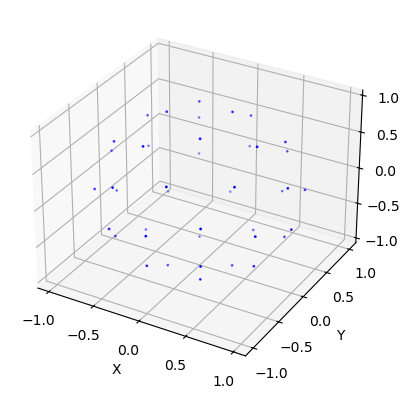

In [8]:
# Create 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2], c='blue', s=1)  # 's' controls point size
# ax.scatter(mesh.faces[:, 0], mesh.faces[:, 1], mesh.faces[:, 2], c='blue', s=1)  # 's' controls point size

# Optional: set axis labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Show plot
plt.show()

# Put TEC data onto the mesh

In [55]:
# Flatten TEC

# Define grid lat/lon: assume lat runs from 90 to -90 and lon from -180 to 180
lat = torch.linspace(90, -90, 180)   # 180 lat points
lon = torch.linspace(-180, 180, 360) # 360 lon points

# Flatten lat/lon to match the 2D grid (meshgrid and flatten)
lat_grid, lon_grid = torch.meshgrid(lat, lon, indexing='ij')
grid_lat_nodes = lat_grid.flatten().numpy()
grid_lon_nodes = lon_grid.flatten().numpy()

# Flatten the TEC map
tec_flat = tec_map.flatten().unsqueeze(1)  # shape (N, 1)

In [56]:
# Grid to mesh mapping

mesh = icosahedral_mesh.get_last_triangular_mesh_for_sphere(splits=4)
mesh_lat, mesh_lon = model_utils.lat_lon_deg_to_spherical(mesh.vertices[:,0], mesh.vertices[:,1])

grid_indices, mesh_indices = grid_mesh_connectivity.in_mesh_triangle_indices(
    grid_latitude=lat.numpy(), 
    grid_longitude=lon.numpy(), 
    mesh=mesh
)

In [57]:
# Compute spatial features for bipartite graph
senders_node_features, receivers_node_features, edge_features = model_utils.get_bipartite_graph_spatial_features(
    senders_node_lat=grid_lat_nodes,
    senders_node_lon=grid_lon_nodes,
    receivers_node_lat=mesh_lat,
    receivers_node_lon=mesh_lon,
    senders=grid_indices,
    receivers=mesh_indices,
    add_node_positions=False,
    add_node_latitude=True,
    add_node_longitude=True,
    add_relative_positions=True,
    relative_longitude_local_coordinates=True,
    relative_latitude_local_coordinates=True
)


In [ ]:
# Create TypedGraph
n_grid_node = np.array([len(grid_lat_nodes)])
n_mesh_node = np.array([len(mesh_lat)])
n_edge = np.array([len(grid_indices)])

grid_node_set = NodeSet(
    n_node=n_grid_node,
    features=tec_flat.numpy()  # torch to numpy
)

mesh_node_set = NodeSet(
    n_node=n_mesh_node,
    features=receivers_node_features
)

edge_set = EdgeSet(
    n_edge=n_edge,
    indices=EdgesIndices(senders=grid_indices, receivers=mesh_indices),
    features=edge_features
)

nodes = {
    "grid_nodes": grid_node_set,
    "mesh_nodes": mesh_node_set
}

edges = {
    EdgeSetKey("grid2mesh", ("grid_nodes", "mesh_nodes")): edge_set
}

graph = TypedGraph(
    context=Context(n_graph=np.array([1]), features=()),
    nodes=nodes,
    edges=edges
)

In [67]:
print(n_mesh_node, len(n_grid_node), len(n_edge))

[2562] 1 1


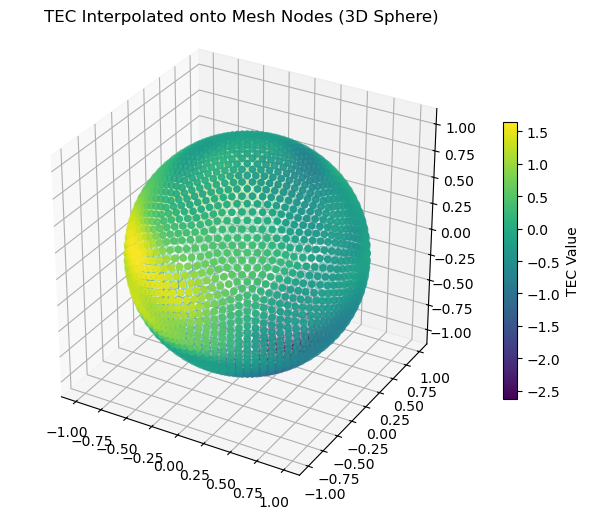

In [62]:
# Visualize the mesh with TEC values
edge = graph.edges[("grid2mesh", ("grid_nodes", "mesh_nodes"))]
senders = edge.indices.senders
receivers = edge.indices.receivers
grid_tec = graph.nodes["grid_nodes"].features[:, 0]  # (N_grid,)

# Create empty accumulator for each mesh node
num_mesh_nodes = graph.nodes["mesh_nodes"].n_node[0]
mesh_values = np.zeros(num_mesh_nodes)
counts = np.zeros(num_mesh_nodes)

# Aggregate TEC from connected grid nodes
for g_idx, m_idx in zip(senders, receivers):
    mesh_values[m_idx] += grid_tec[g_idx]
    counts[m_idx] += 1

# Avoid division by zero
counts = np.where(counts == 0, 1, counts)
mesh_tec = mesh_values / counts

# Plot
vertices = mesh.vertices  # shape (N, 3), assumed normalized to unit sphere

x, y, z = vertices[:, 0], vertices[:, 1], vertices[:, 2]
norm = plt.Normalize(mesh_tec.min(), mesh_tec.max())

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(x, y, z, c=mesh_tec, cmap="viridis", norm=norm, s=20)

ax.set_title("TEC Interpolated onto Mesh Nodes (3D Sphere)")
ax.set_box_aspect([1, 1, 1])
fig.colorbar(sc, ax=ax, shrink=0.6, label="TEC Value")
plt.show()

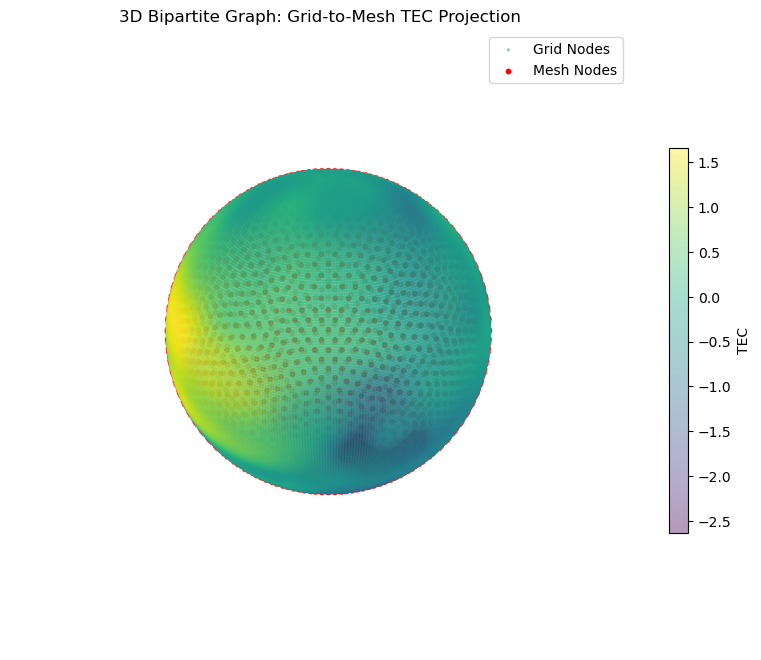

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Convert lat/lon to 3D coordinates
vertices = mesh.vertices  # shape (N, 3), assumed normalized to unit sphere
mesh_x, mesh_y, mesh_z = vertices[:, 0], vertices[:, 1], vertices[:, 2]
mesh_xyz = np.array([mesh_x, mesh_y, mesh_z]).T  # (M, 3)
grid_xyz = np.array([np.cos(np.radians(grid_lat_nodes)) * np.cos(np.radians(grid_lon_nodes)),
                     np.cos(np.radians(grid_lat_nodes)) * np.sin(np.radians(grid_lon_nodes)),
                     np.sin(np.radians(grid_lat_nodes))]).T  # (N, 3

# 2. Prepare edge connections
senders = grid_indices
receivers = mesh_indices

# 3. Plot setup
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
ax.axis('off')

# 4. Plot grid nodes (colored by TEC)
tec_values = tec_flat.squeeze().numpy()
p = ax.scatter(grid_xyz[:, 0], grid_xyz[:, 1], grid_xyz[:, 2],
               c=tec_values, cmap='viridis', s=2, alpha=0.4, label="Grid Nodes")

# 5. Plot mesh nodes
ax.scatter(mesh_xyz[:, 0], mesh_xyz[:, 1], mesh_xyz[:, 2],
           color='red', s=10, label="Mesh Nodes")

# 6. Plot subset of edges (downsample for speed)
max_edges_to_plot = 500
step = max(1, len(senders) // max_edges_to_plot)

for i in range(0, len(senders), step):
    start = grid_xyz[senders[i]]
    end = mesh_xyz[receivers[i]]
    ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], color='gray', alpha=0.05)

# 7. Colorbar and legend
fig.colorbar(p, ax=ax, shrink=0.5, label="TEC")
ax.legend()

plt.title("3D Bipartite Graph: Grid-to-Mesh TEC Projection")
plt.show()
